In [1]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(sys.path[-1])

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/Assignment-2


In [ ]:
from src.classifiers import pipeline
from src.visualizations import visualize_training_summary_boxplots, tabulate_hyperparameter_spaces
import pandas as pd
import joblib

In [3]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
CLASSIFIERS = [
    "LogisticRegression",
    "GaussianNB",
    "LinearDiscriminantAnalysis",
    "SVC",
    "RandomForestClassifier",
    "LGBMClassifier"
]
DF = pd.read_csv(os.path.join(DATA_DIR, "breast_cancer.csv"))
TARGET = "diagnosis"
N_ROUNDS = 10
N_OUTER_FOLDS = 5
N_INNER_FOLDS = 3
N_FEATURES_TO_SELECT = 10
N_OPTUNA_TRIALS = 100           # Number of trials for Optuna
VALIDATION_SET_FRACTION = 0.1
SEED = 42

In [4]:
# # NOTE:
# # The pipeline function took around 65 minutes to run on my machine with
# # 10 rounds, 5 outer folds, 3 inner folds, 100 optuna trials, and 6 classifiers
# # using 16 GB of RAM. USE LESS OPTUNA TRIALS IF YOU WANT TO RUN IT FASTER.

# val_set = pipeline(
#         classifiers=CLASSIFIERS,
#         df=DF,
#         target=TARGET,
#         models_dir=MODELS_DIR,
#         results_dir=RESULTS_DIR,
#         n_rounds=N_ROUNDS,
#         n_outer_folds=N_OUTER_FOLDS,
#         n_inner_folds=N_INNER_FOLDS,
#         n_features_to_select=N_FEATURES_TO_SELECT,
#         n_optuna_trials=N_OPTUNA_TRIALS,
#         validation_set_fraction=VALIDATION_SET_FRACTION,
#         seed=SEED
# )

In [5]:
# # NOTE: Here I am savign the holdout set for a final evaluation

# val_set.to_csv(os.path.join(DATA_DIR, "validation_set.csv"), index=False)

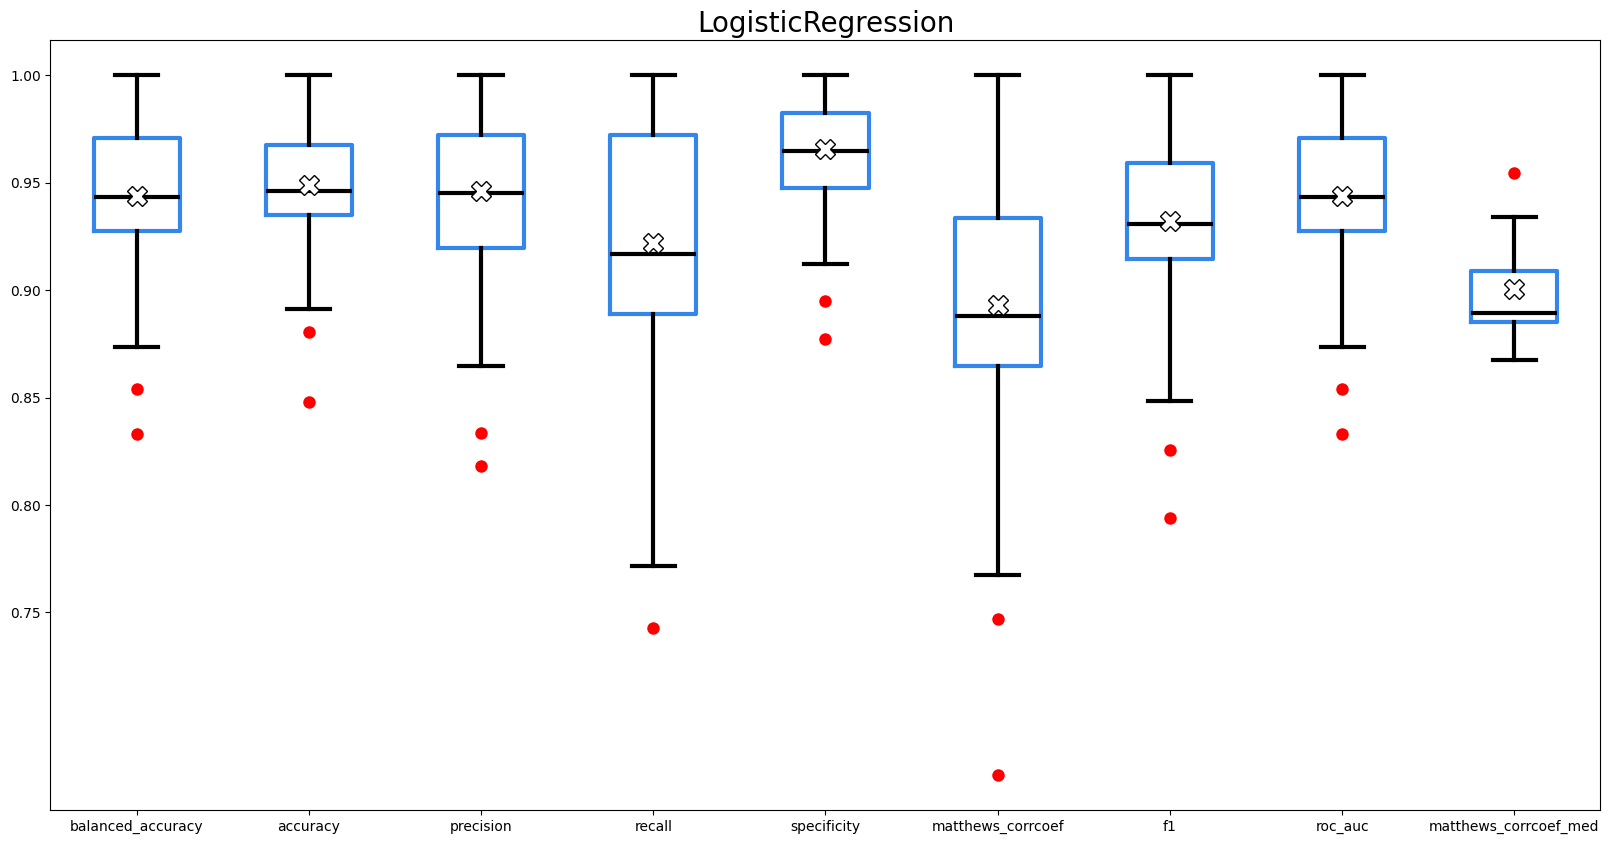

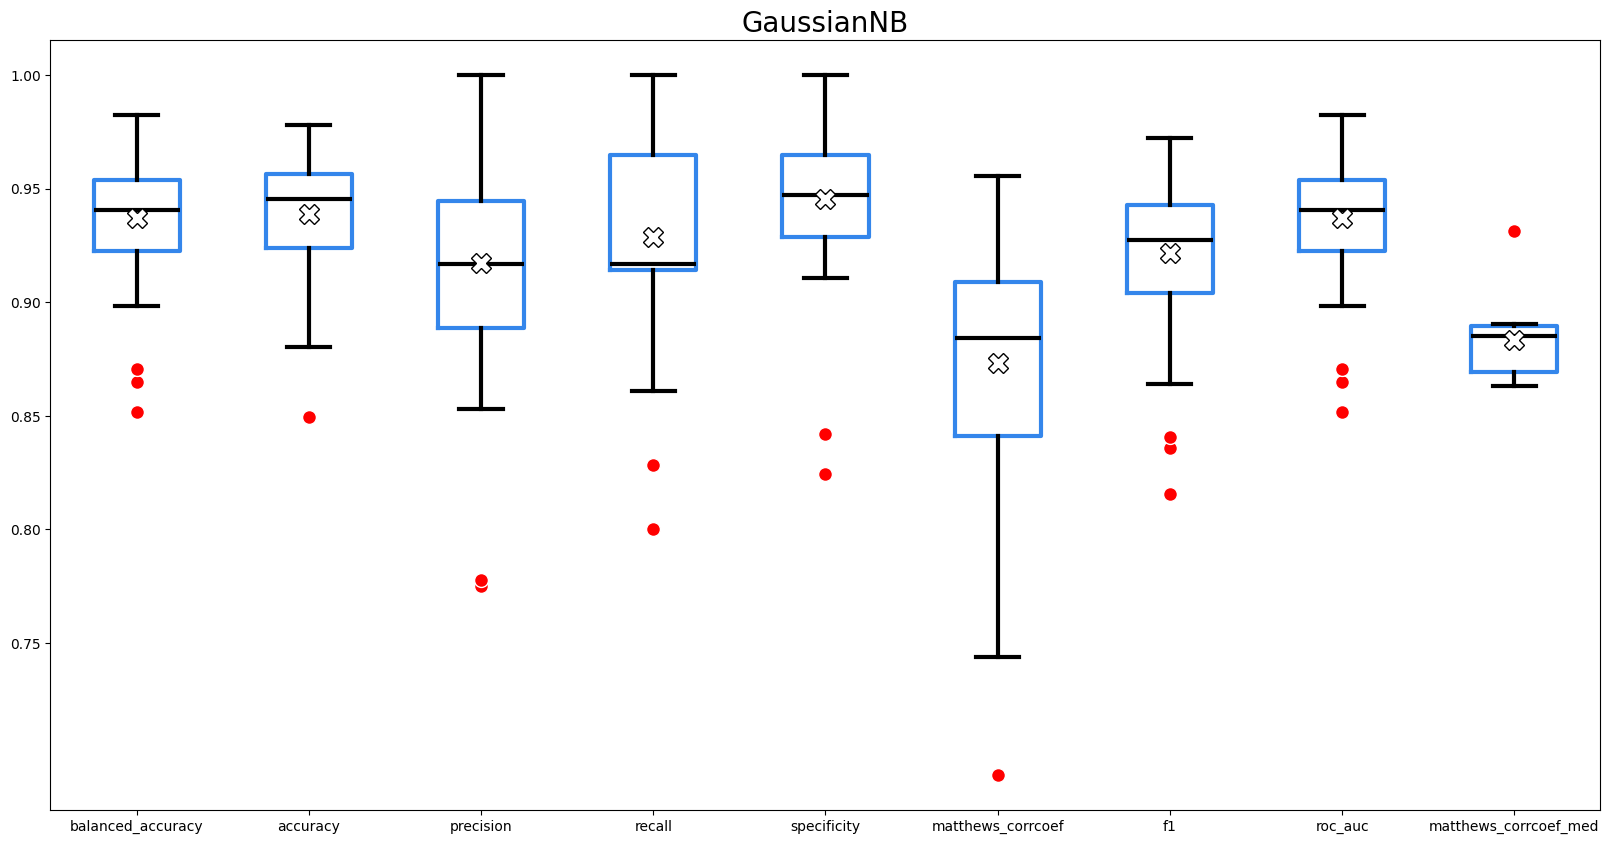

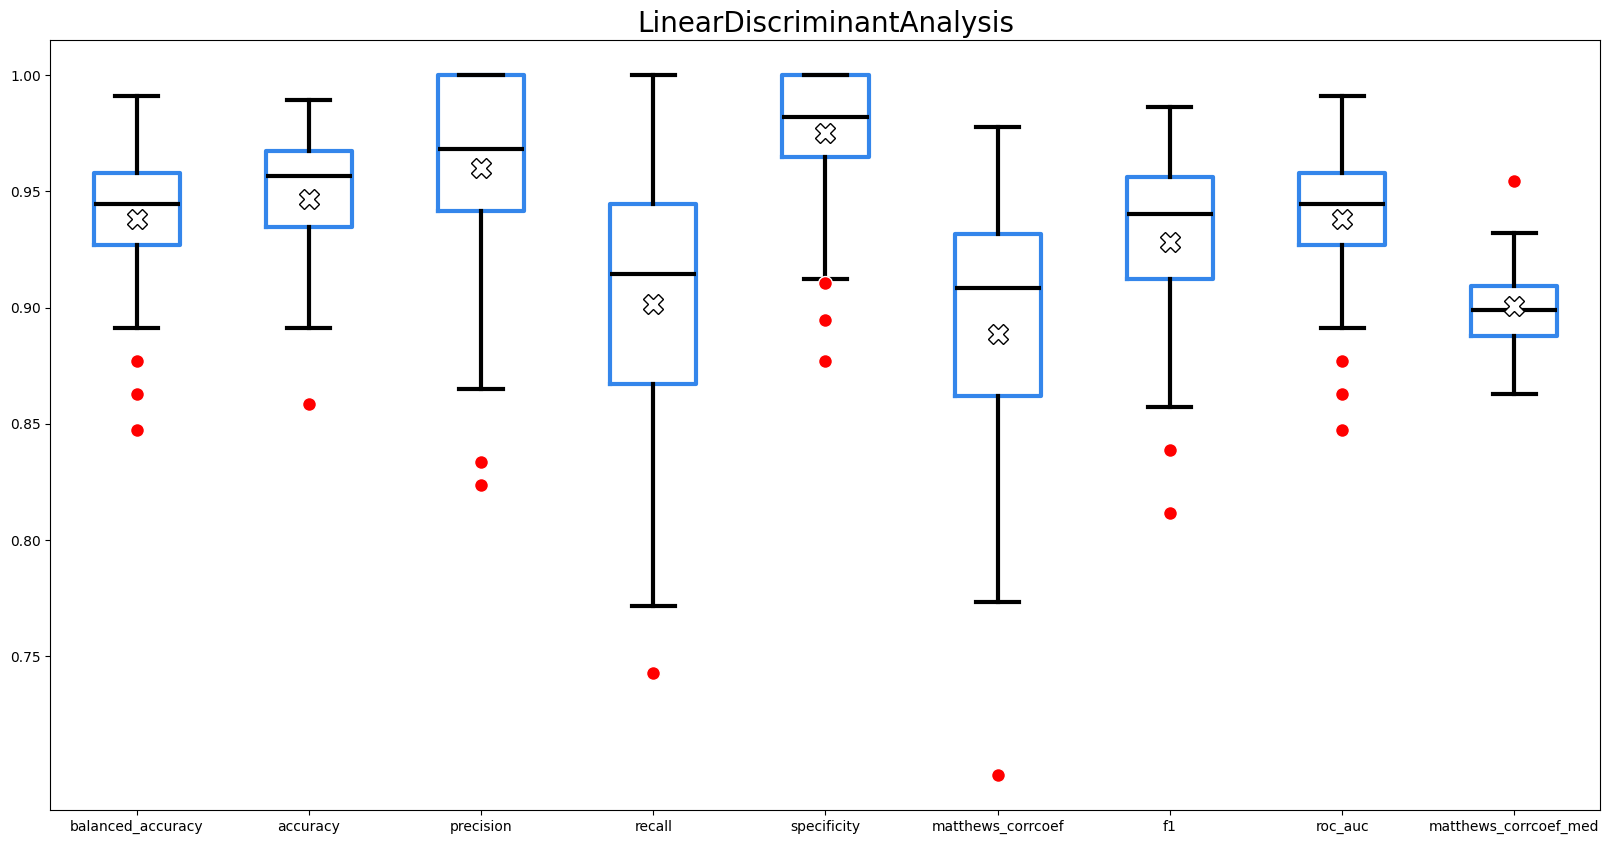

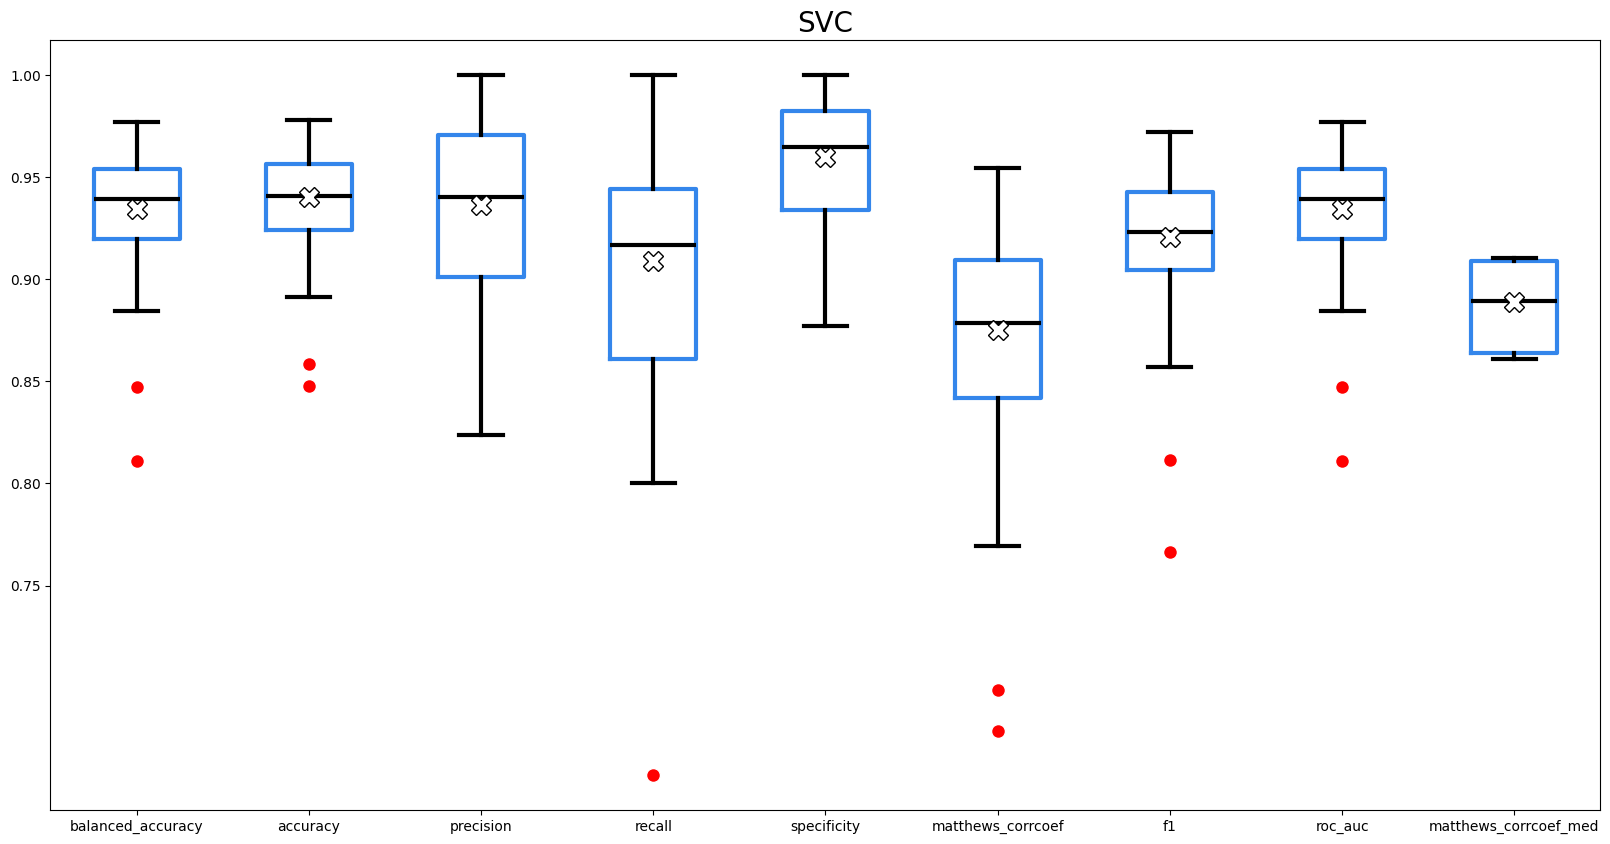

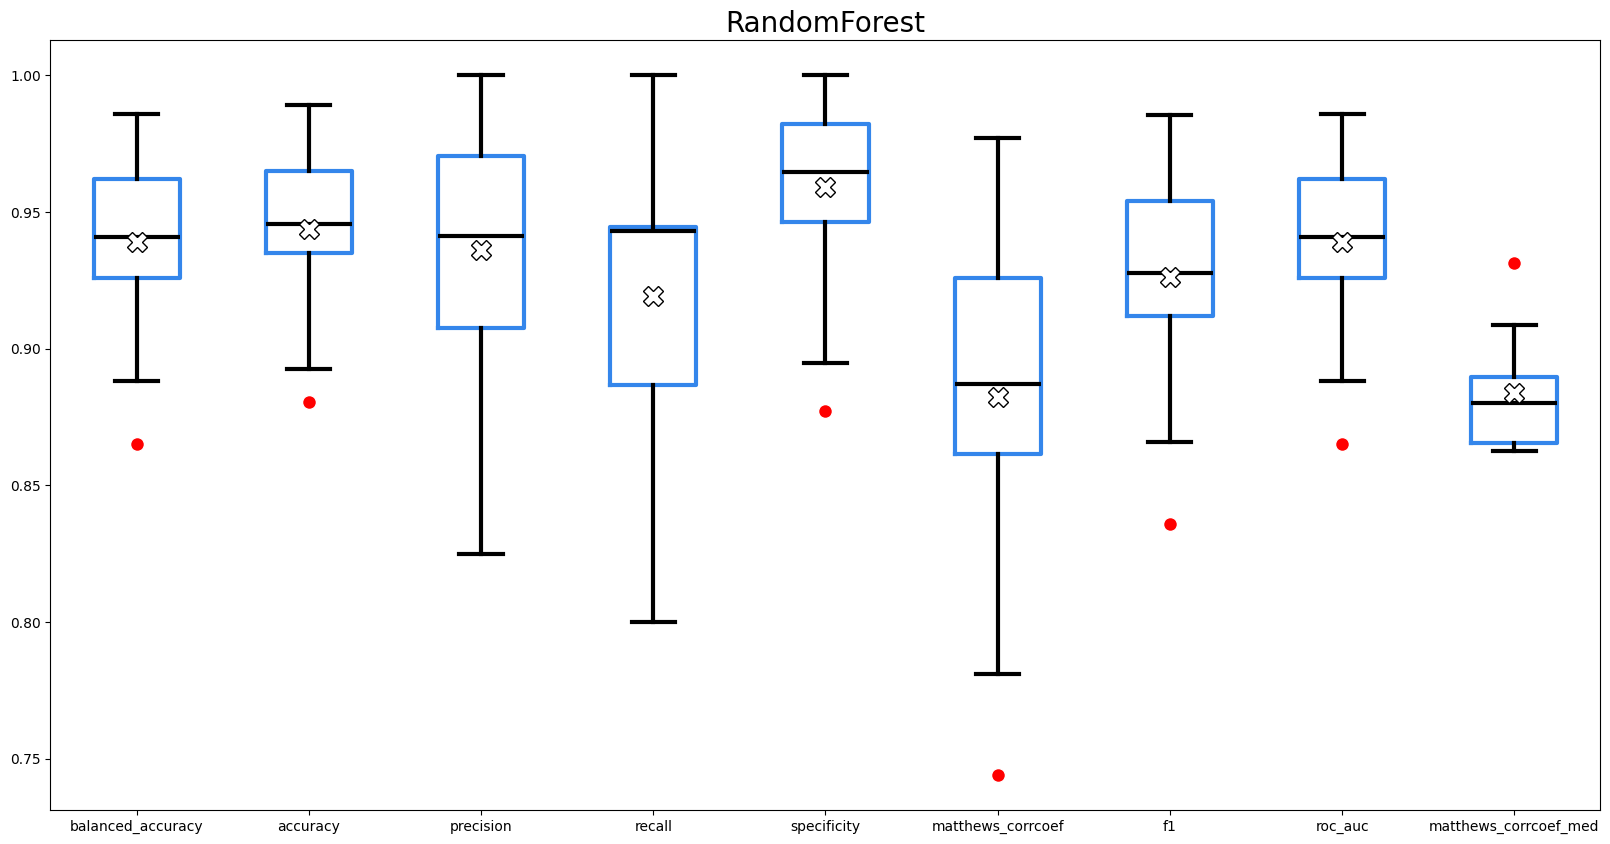

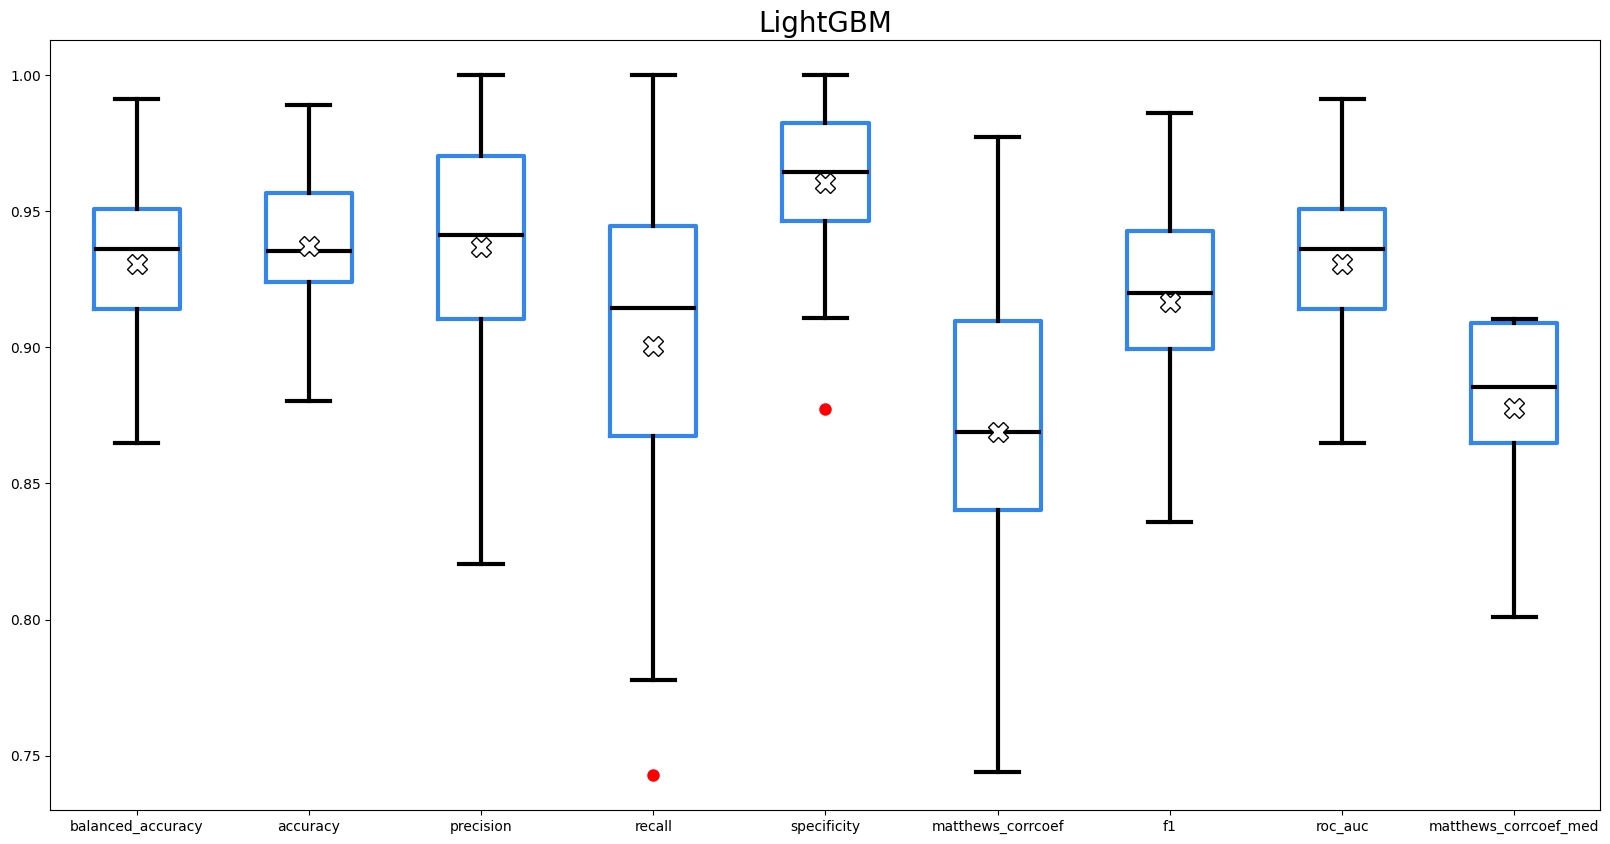

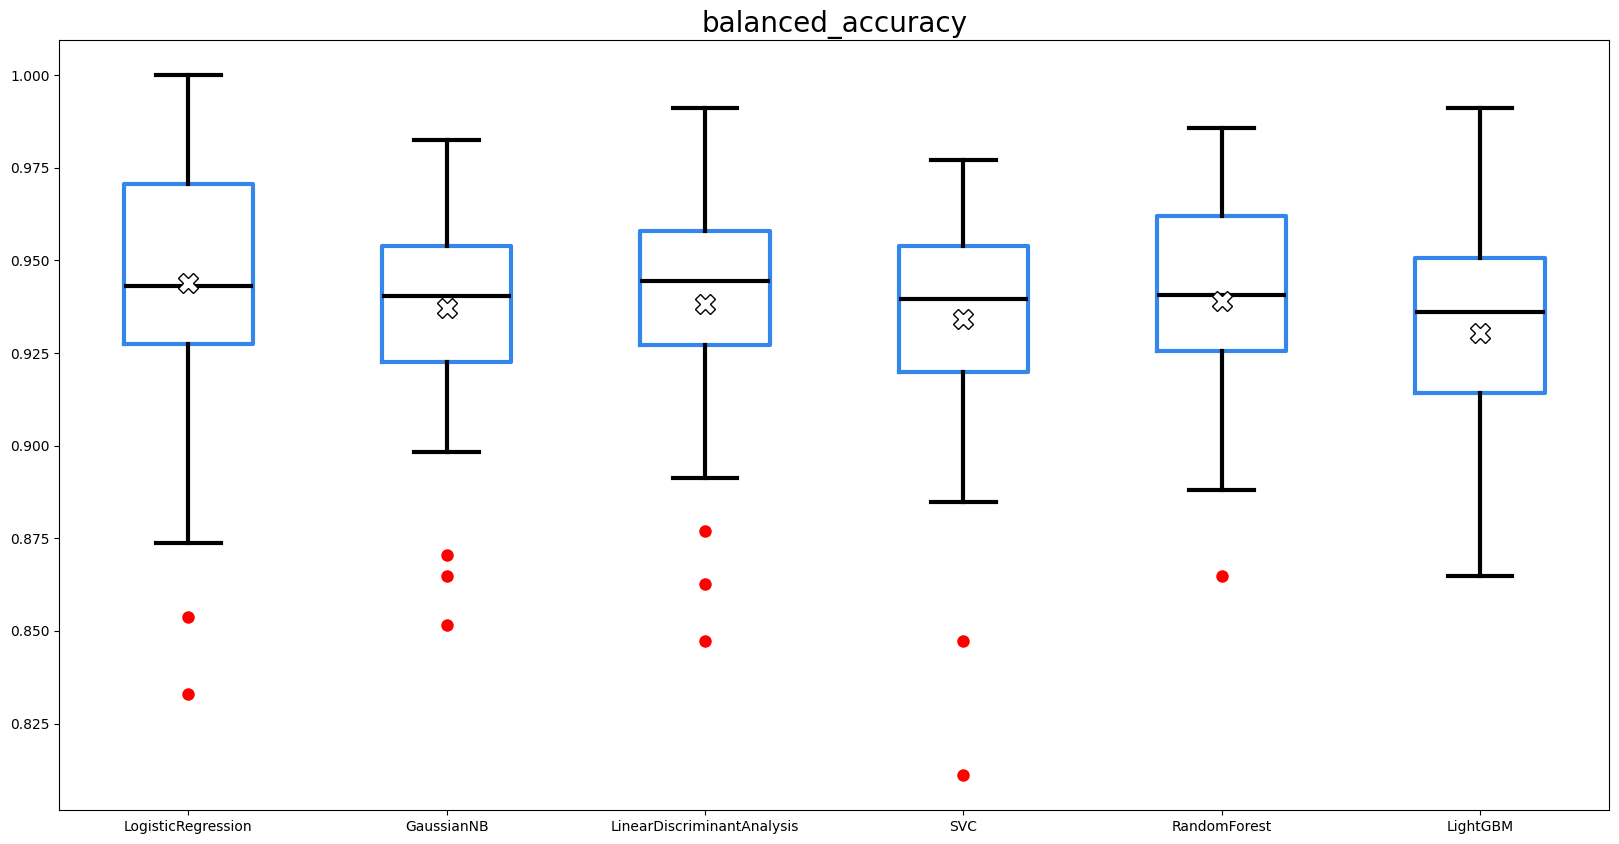

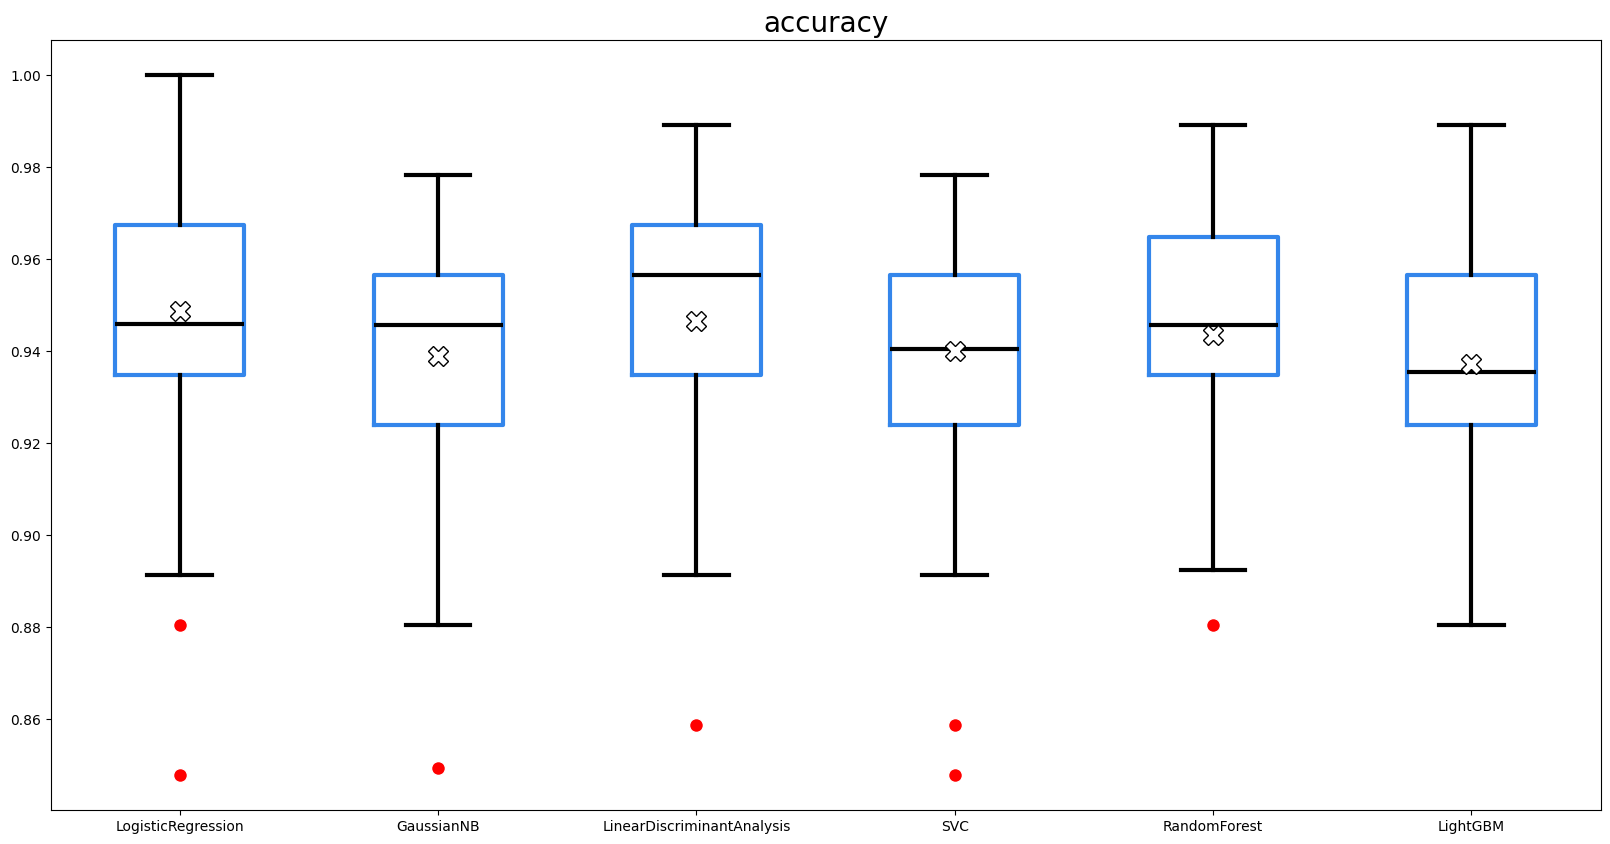

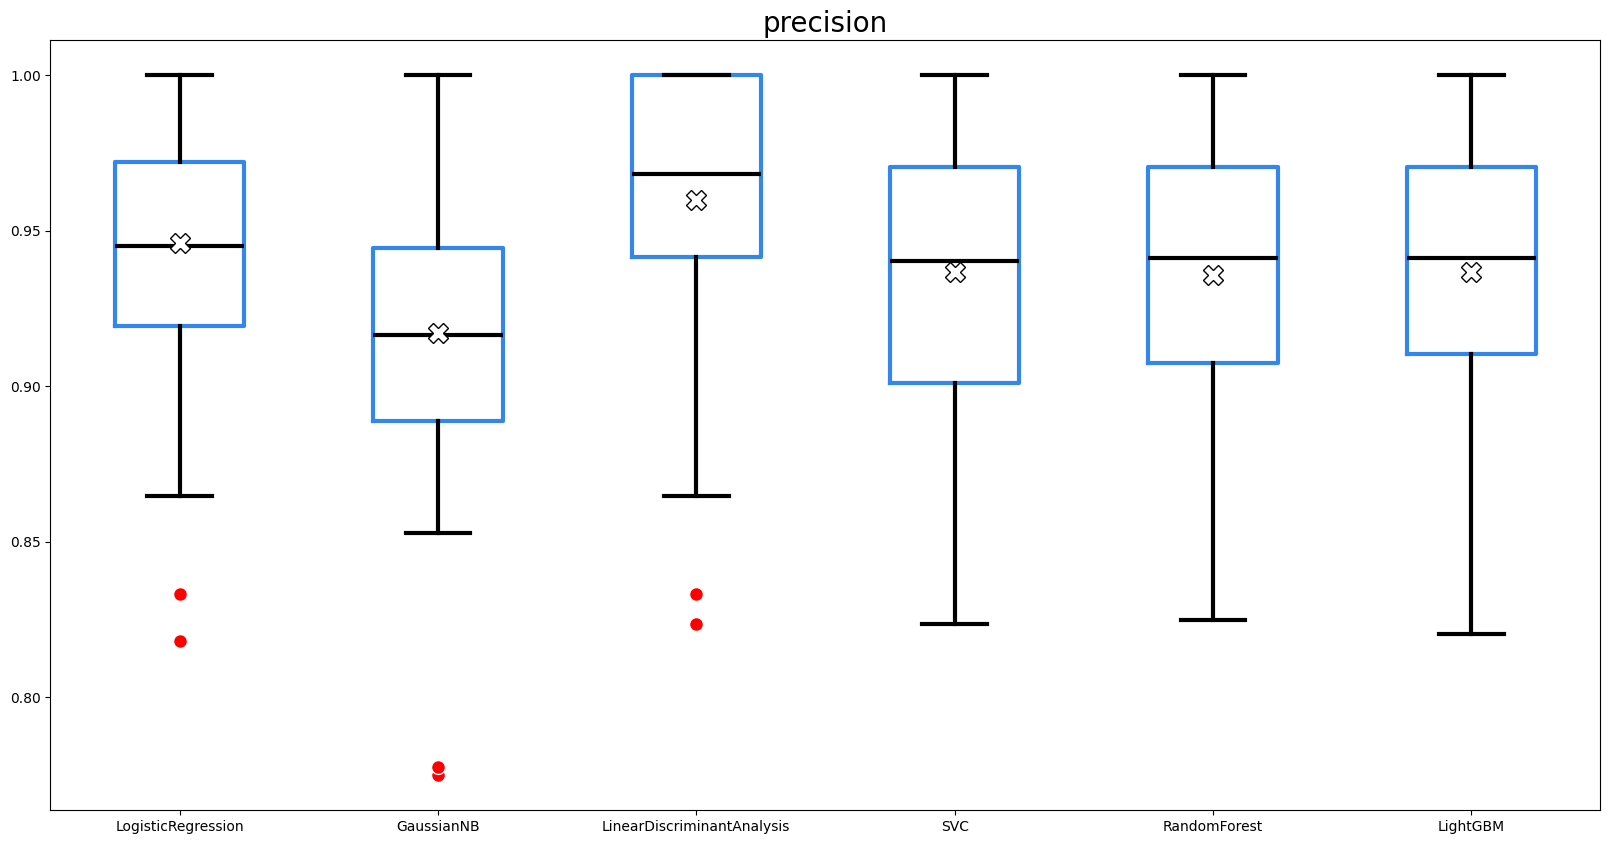

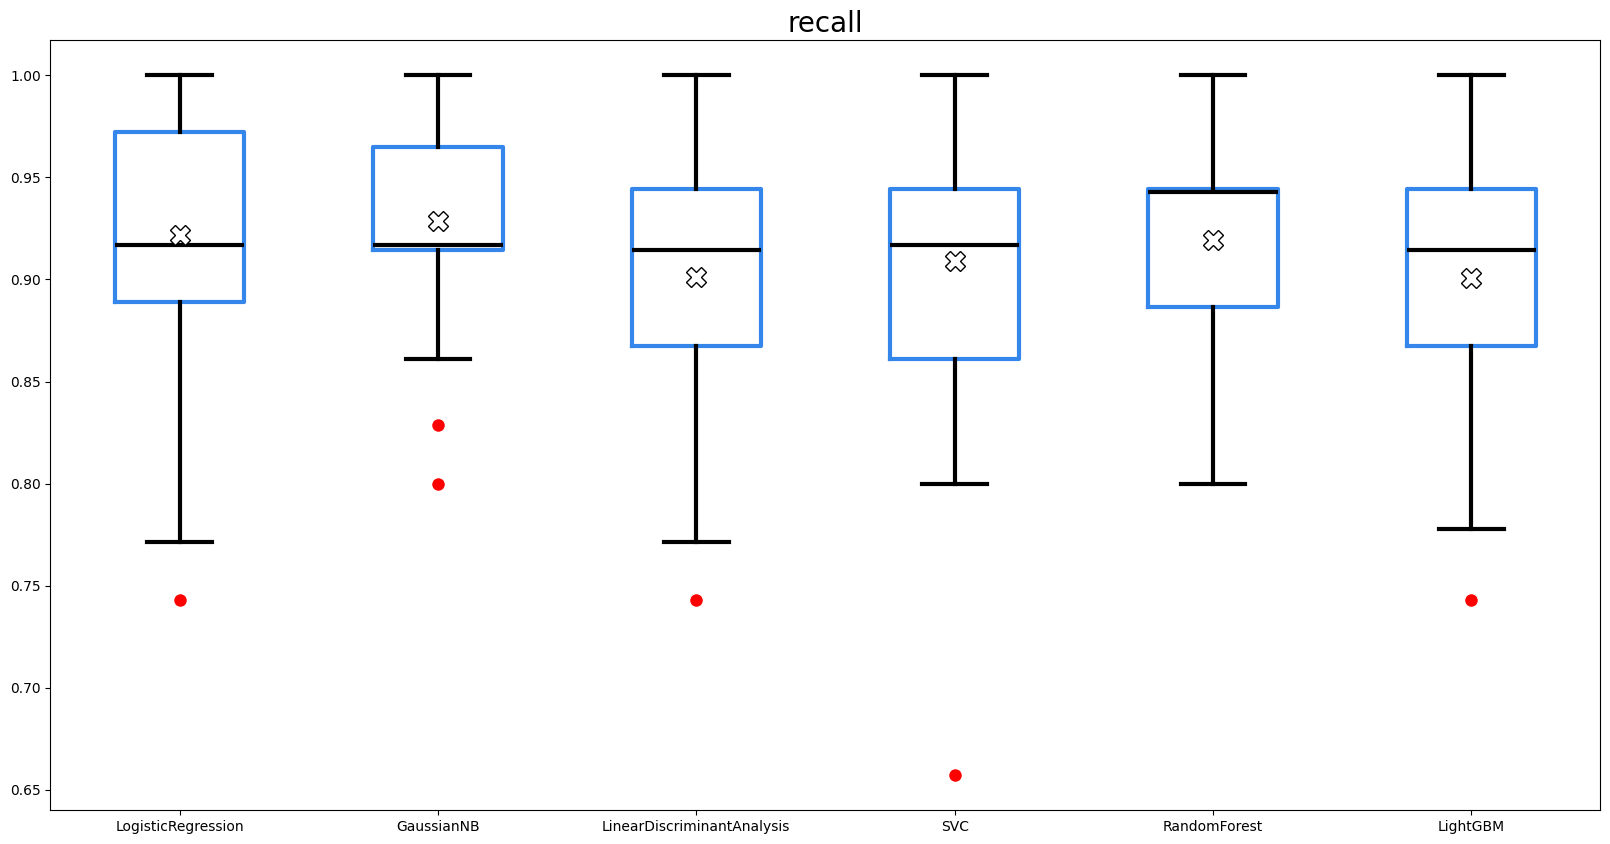

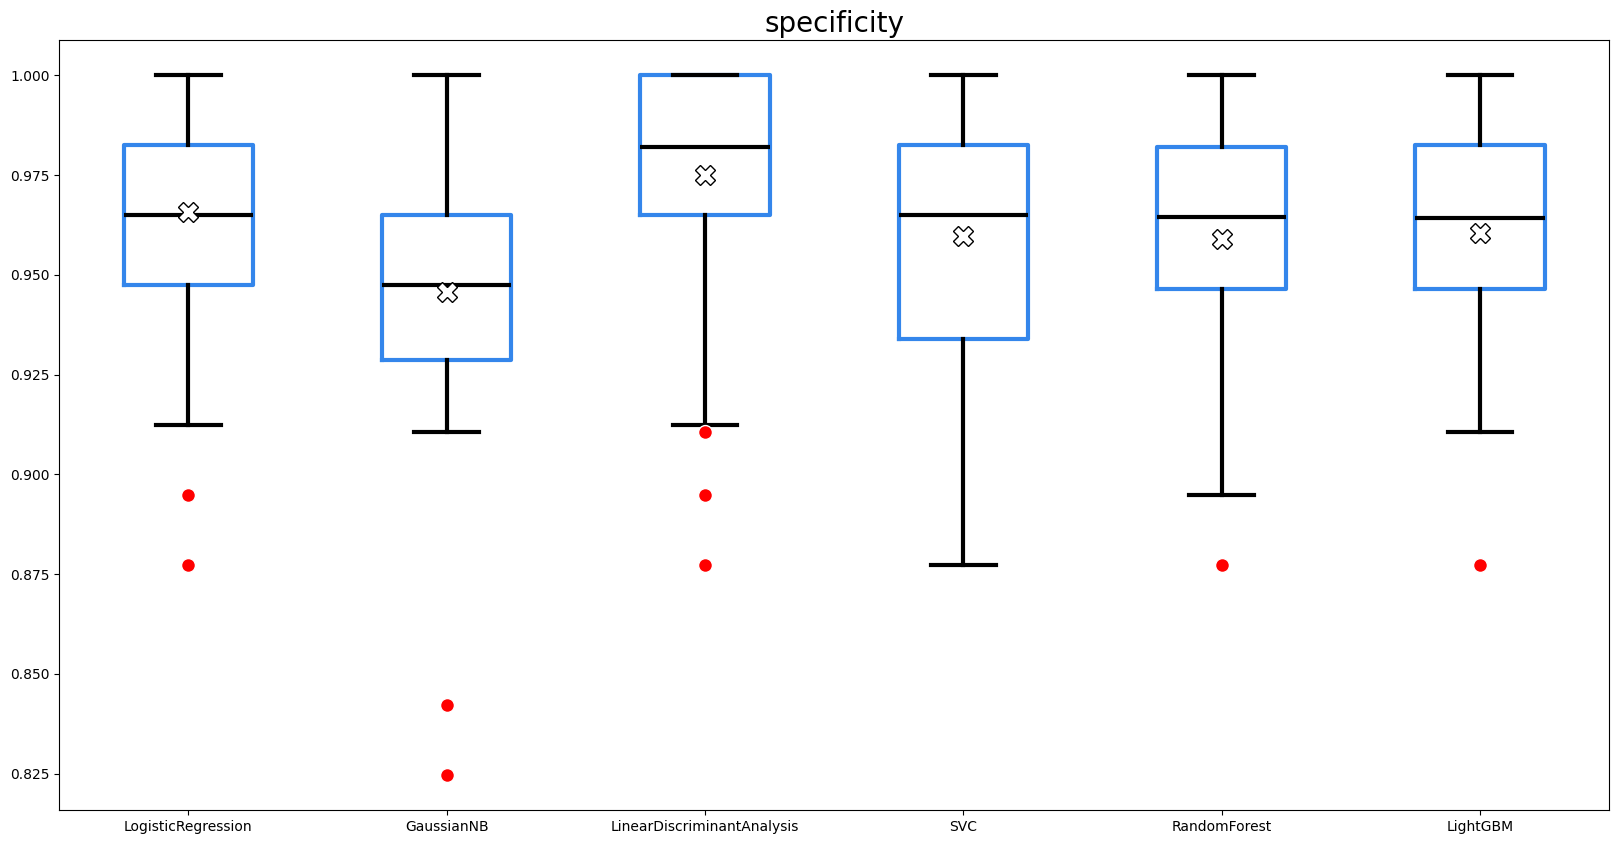

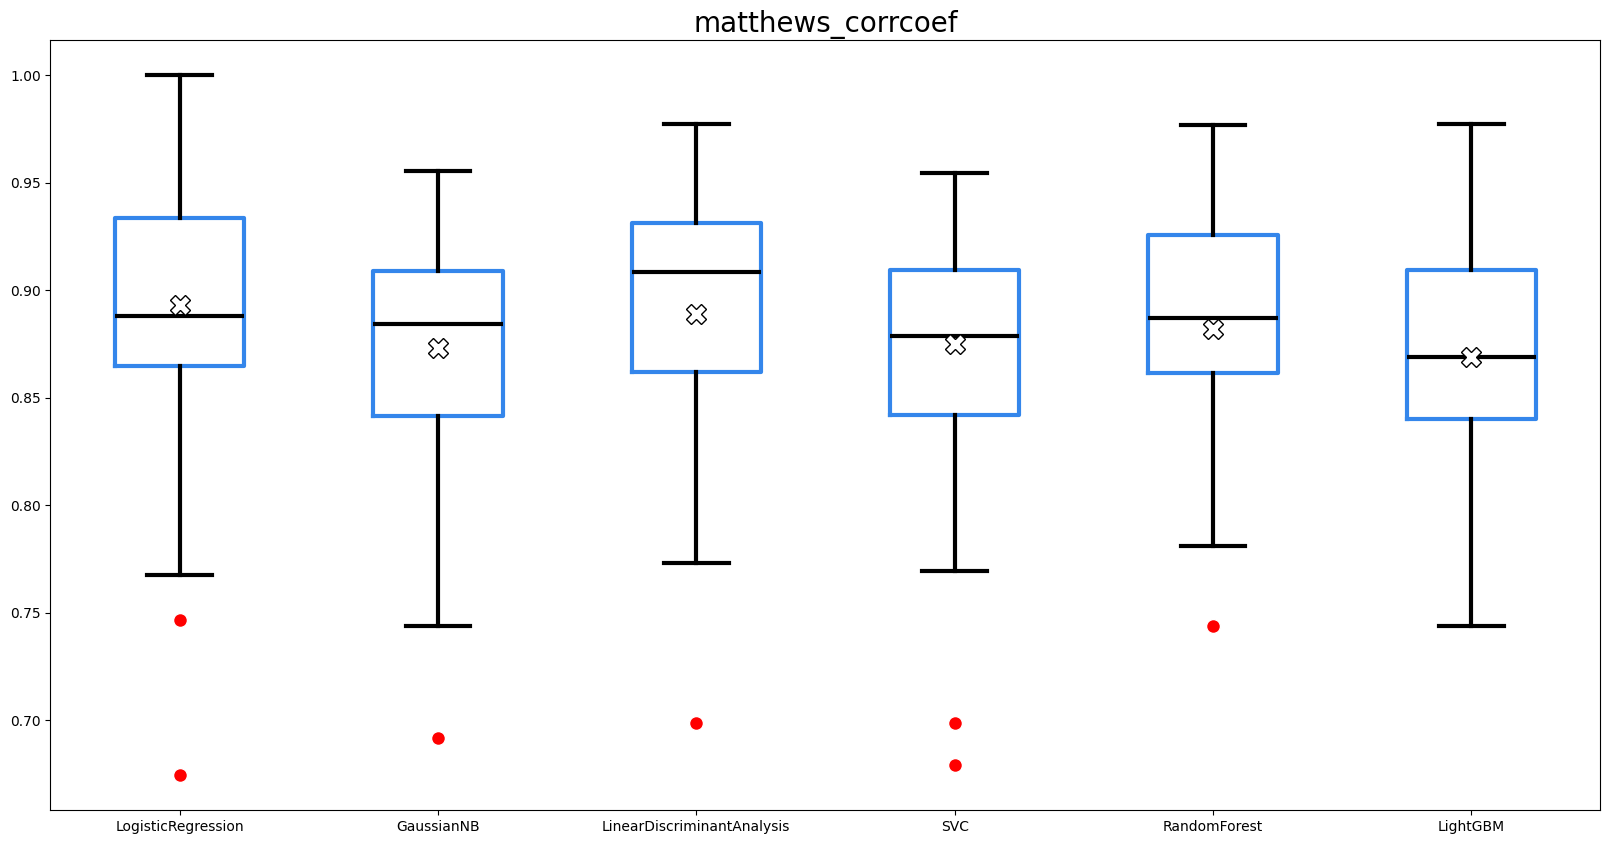

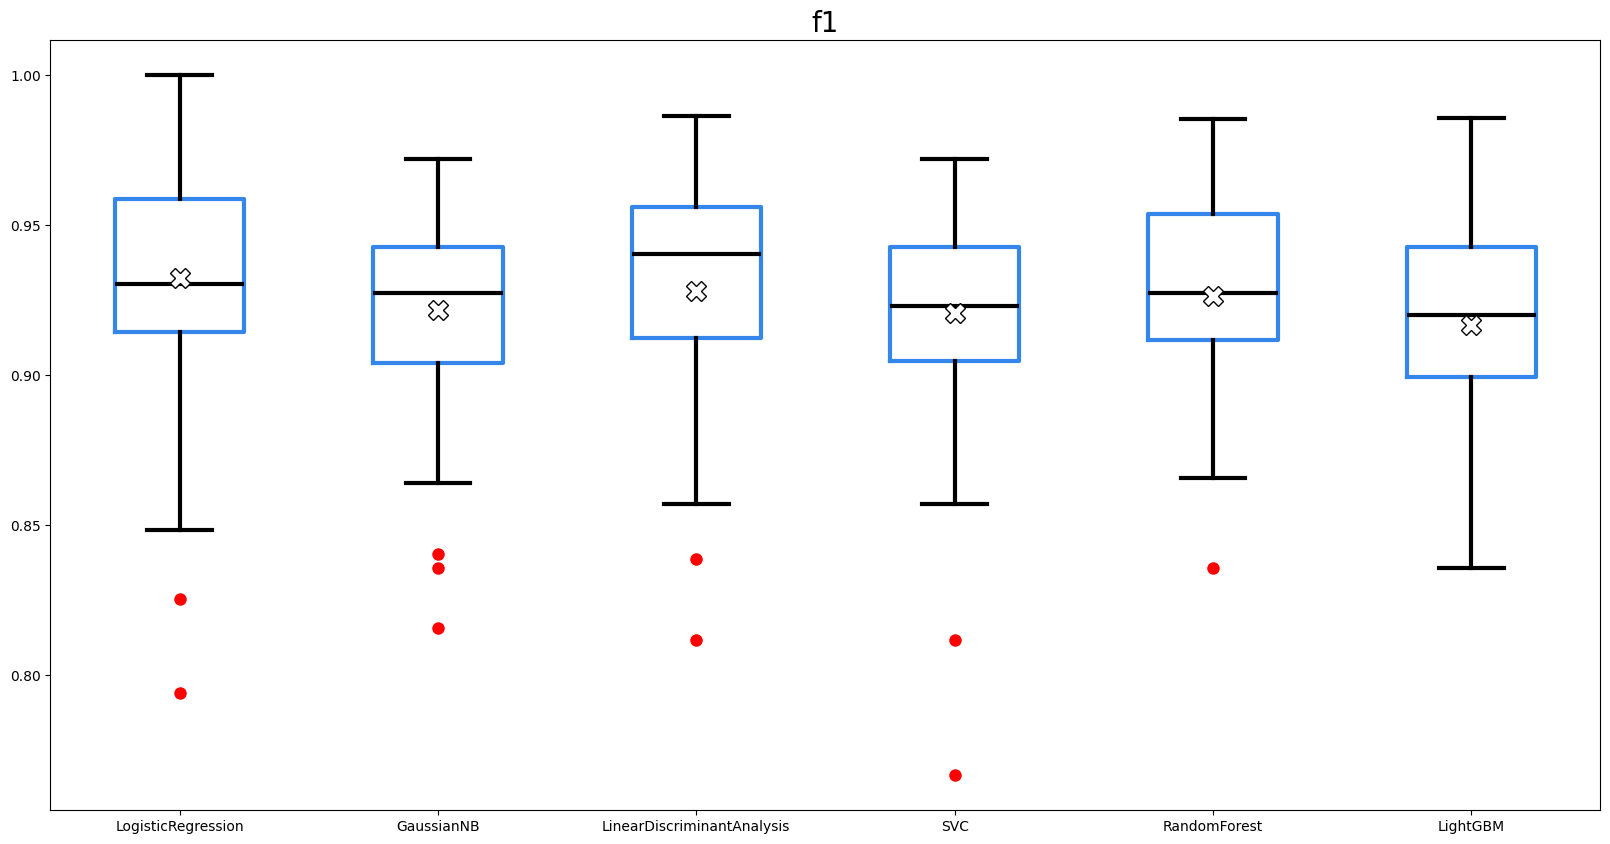

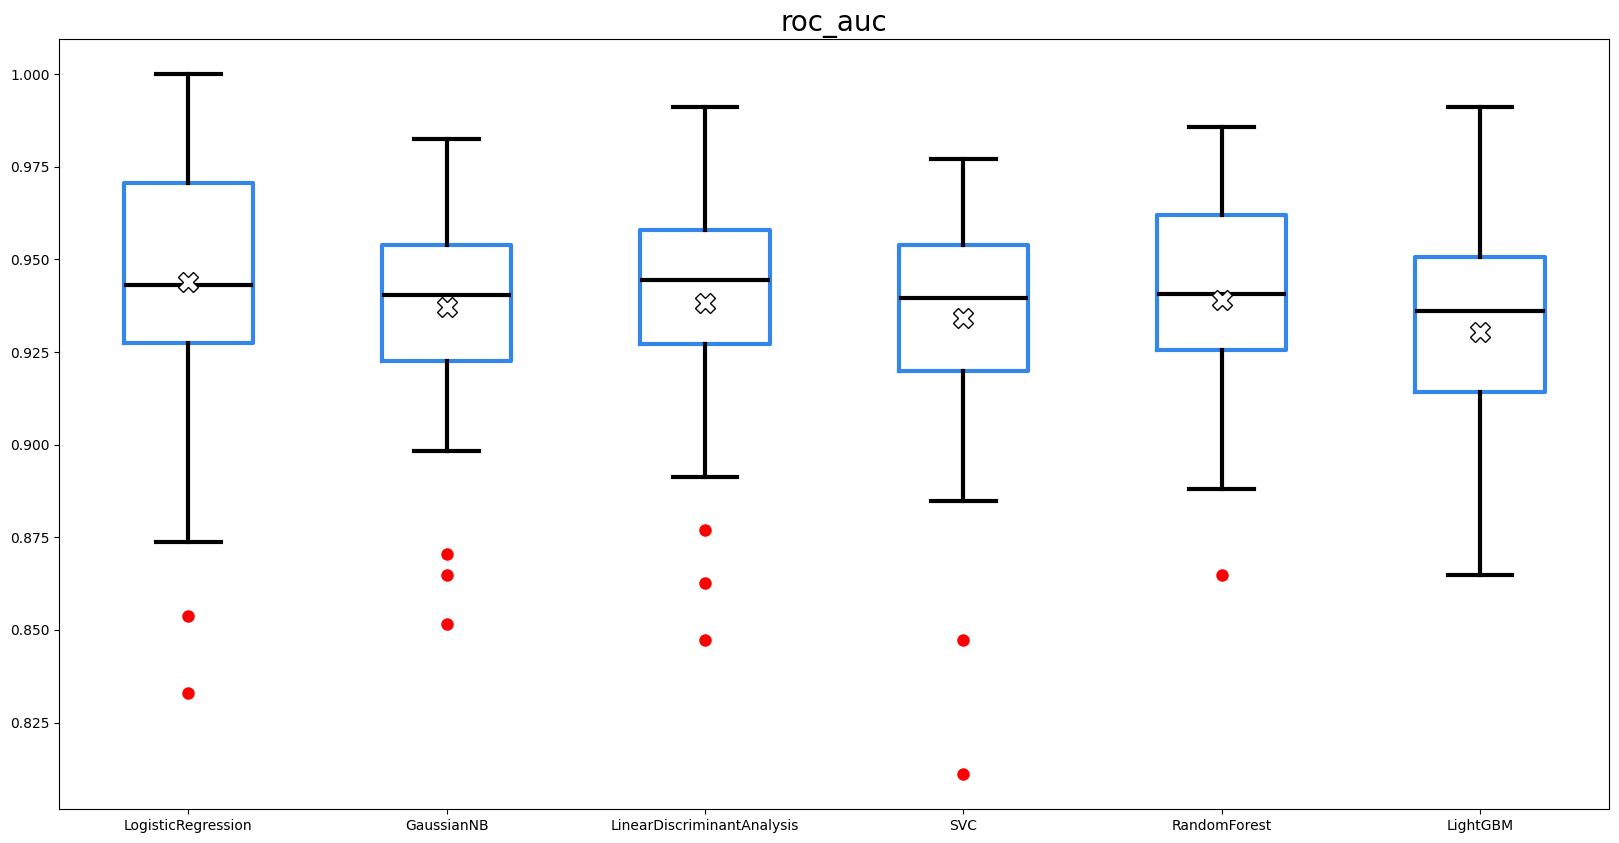

In [6]:
dfLR = pd.read_csv(
    os.path.join(RESULTS_DIR, "LogisticRegression_summary.csv")
)
dfGNB = pd.read_csv(
    os.path.join(RESULTS_DIR, "GaussianNB_summary.csv")
)
dfLDA = pd.read_csv(
    os.path.join(RESULTS_DIR, "LinearDiscriminantAnalysis_summary.csv")
)
dfSVC = pd.read_csv(
    os.path.join(RESULTS_DIR, "SVC_summary.csv")
)
dfRF = pd.read_csv(
    os.path.join(RESULTS_DIR, "RandomForestClassifier_summary.csv")
)
dfLGBM = pd.read_csv(
    os.path.join(RESULTS_DIR, "LGBMClassifier_summary.csv")
)

visualize_training_summary_boxplots(
    names=[
        "LogisticRegression", "GaussianNB", "LinearDiscriminantAnalysis",
        "SVC", "RandomForest", "LightGBM"
    ],
    dfs=[dfLR, dfGNB, dfLDA, dfSVC, dfRF, dfLGBM],
    boxplot_kws={
        "figsize": (20, 10),
        "metrics": [
            "balanced_accuracy", "accuracy", "precision", "recall",
            "specificity", "matthews_corrcoef", "f1", "roc_auc"
        ],
        "showmeans": True,
        "meanprops": {
            "marker": "X", "markerfacecolor": "white",
            "markeredgecolor": "black", "markersize": 15
        },
        "boxprops": {
            "linewidth": 3, "color": "#3486eb"
        },
        "medianprops": {
            "color": "black", "linewidth": 3
        },
        "flierprops": {
            "markerfacecolor": "red", "markeredgecolor": "white",
            "markersize": 10
        },
        "wiswidth": 3
    }
)

In [7]:
tabulate_hyperparameter_spaces(
    [
        "LogisticRegression",
        "GaussianNB",
        "LinearDiscriminantAnalysis",
        "SVC",
        "RandomForestClassifier",
        "LGBMClassifier"
    ],
    [
        os.path.join(MODELS_DIR, "LogisticRegression_params.json"),
        os.path.join(MODELS_DIR, "GaussianNB_params.json"),
        os.path.join(MODELS_DIR, "LinearDiscriminantAnalysis_params.json"),
        os.path.join(MODELS_DIR, "SVC_params.json"),
        os.path.join(MODELS_DIR, "RandomForestClassifier_params.json"),
        os.path.join(MODELS_DIR, "LGBMClassifier_params.json")
    ]
)

                LogisticRegression                
C                        |       3078.1224936405915
l1_ratio                 |       0.9940906288744059
max_iter                 |                      102
class_weight             |                     None



                    GaussianNB                    
var_smoothing            |    7.942843970741538e-09



            LinearDiscriminantAnalysis            
solver                   |                      svd
shrinkage                |                     None
priors                   |                 0.5, 0.5



                       SVC                        
C                        |       0.3103413921602419
gamma                    |                     auto
coef0                    |       0.9276369503717264
kernel                   |                  sigmoid
class_weight             |                     None



              RandomForestClassifier              
n_estimators             |                       39
crite

In [ ]:
# Load the holdout set
val_set = pd.read_csv(
    os.path.join(DATA_DIR, "validation_set.csv")
)

# Load the model
model = joblib.load(
    os.path.join(MODELS_DIR, "LinearDiscriminantAnalysis.joblib")
)

# Load the scaler
scaler = joblib.load(
    os.path.join(MODELS_DIR, "LinearDiscriminantAnalysis_scaler.joblib")
)

# Read the selected features
with open(
    os.path.join(MODELS_DIR, "LinearDiscriminantAnalysis_features.txt"),
    "r"
) as fp:
    stream = fp.readlines()
    selected_features = [s.strip() for s in stream]

# Clean up the dataset so it matches what the model expects
X = val_set.drop(columns=[TARGET, "id"])
for col in X.columns:
    if " " in col:
        X.rename(columns={col: col.replace(" ", "_")}, inplace=True)
X = X[selected_features]
y = val_set[TARGET]
y = y.replace({"M": 1, "B": 0})

# Scale the data
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)

# Predict
y_pred = model.predict(X_scaled)